In [1]:
from typing import *
from dataclasses import asdict
from pathlib import Path
import random

import soundfile
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from IPython.display import Audio

from snowfall.common import load_checkpoint, average_checkpoint
from snowfall.models.conformer import Conformer
from snowfall.models.tdnnf import Tdnnf1a
from snowfall.lexicon import Lexicon
from snowfall.training.mmi_graph import get_phone_symbols
from snowfall.training.mmi_graph import create_bigram_phone_lm
from snowfall.training.ctc_graph import build_ctc_topo
from snowfall.training.mmi_graph import MmiTrainingGraphCompiler
from snowfall.common import get_texts

import k2
from k2 import Fsa, SymbolTable

from lhotse import *
from lhotse.dataset import *
from lhotse.features.fbank import FbankConfig
from lhotse.features.kaldi.layers import *
from lhotse.utils import compute_num_frames
from lhotse.utils import INT16MAX

In [2]:
def feature_extraction(
        x: torch.Tensor,
        supervisions: dict = None,
        compute_gradient: bool = False
) -> Tuple[torch.Tensor, dict]:
    """
    Do feature extraction and return feature, supervisions
    """

    params = asdict(FbankConfig())
    params.update({
        "sample_frequency": 16000,
        "num_mel_bins": 80,
        "snip_edges": False
    })
    params['frame_shift'] *= 1000.0
    params['frame_length'] *= 1000.0

    if compute_gradient:
        x.requires_grad = True
    ### start feature extraction
    features_single = []
    for i in range(x.shape[0]):
        feature_i = torchaudio.compliance.kaldi.fbank(x[i].unsqueeze(0), **params)  # [T, C]
        features_single.append(feature_i)
    feature = torch.stack(features_single)

    if supervisions is not None:
        start_frames = [
            compute_num_frames(sample.item() / 16000, params['frame_shift'] / 1000, 16000)
            for sample in supervisions['start_sample']
        ]
        supervisions['start_frame'] = torch.LongTensor(start_frames)

        num_frames = [
            compute_num_frames(sample.item() / 16000, params['frame_shift'] / 1000, 16000)
            for sample in supervisions['num_samples']
        ]
        supervisions['num_frames'] = torch.LongTensor(num_frames)

    return feature, supervisions


def feature_extraction2(
        x: torch.Tensor,
        supervisions: dict = None,
        compute_gradient: bool = False
) -> Tuple[torch.Tensor, dict]:
    """
    Do feature extraction and return feature, supervisions
    """
    
    fbank = Wav2LogFilterBank()

    if compute_gradient:
        x.requires_grad = True

    feature = fbank(x)

    if supervisions is not None:
        start_frames = [
            compute_num_frames(sample.item() / 16000, fbank.frame_shift, 16000)
            for sample in supervisions['start_sample']
        ]
        supervisions['start_frame'] = torch.LongTensor(start_frames)

        num_frames = [
            compute_num_frames(sample.item() / 16000, fbank.frame_shift, 16000)
            for sample in supervisions['num_samples']
        ]
        supervisions['num_frames'] = torch.LongTensor(num_frames)

    return feature, supervisions

In [3]:
def forward_pass(
    feature,
    supervisions,
    supervision_segments,
    texts,
    model,
    loss_fn,
    device
):
#     feature = feature.to(device)
    # at entry, feature is [N, T, C]
    feature = feature.permute(0, 2, 1)  # now feature is [N, C, T]

    nnet_output, encoder_memory, memory_mask = model(feature, supervisions)

    # nnet_output is [N, C, T]
    nnet_output = nnet_output.permute(0, 2, 1)  # now nnet_output is [N, T, C]

    mmi_loss, tot_frames, all_frames = loss_fn(nnet_output, texts, supervision_segments)

    assert nnet_output.device == device, f'{nnet_output.device} != {device}'

    loss = (-mmi_loss) / (len(texts))

    return loss, tot_frames, all_frames


def fgsm_attack(
    audio,
    supervisions,
    supervision_segments,
    texts,
    model,
    loss_fn,
    device = 'cpu',
    eps=0.01
):
    audio = audio.clone().to(device)
    eps = eps * audio.detach().abs().max().data
    feature, _ = feature_extraction(audio, compute_gradient=True)
    loss, tot_frames, all_frames = forward_pass(
        feature, 
        supervisions,
        supervision_segments,
        texts, 
        model,
        loss_fn,
        device,
    )
    loss.backward()  # to get input gradients
    assert audio.grad is not None
    audio_adv = audio + audio.grad.data.sign() * eps
    audio_adv = torch.clamp(audio_adv, min=-1.0, max=1.0)
    audio = audio_adv.detach()
    return audio


def pgd_attack(audio,
               supervisions,
               supervision_segments,
               texts,
               model,
               loss_fn,
               device = 'cpu',
               eps=0.01,
               iters=7,
               rand_prob=0.0):
    audio = audio.clone().to(device)
    audio_ori = audio
    eps = eps * audio.detach().abs().max().data
    # 1.5 is a magic number to make it more likely for PGD to actually
    # reach the given epsilon for some samples
    alpha = 1.5 * (1 / iters) * audio.detach().abs().max().data
    if torch.rand(1) < rand_prob:
        rand_pert = torch.rand_like(audio) * 2 * eps - eps
        audio = audio + rand_pert
    for i in range(iters):
        feature, _ = feature_extraction(audio, compute_gradient=True)
        loss, tot_frames, all_frames = forward_pass(
            feature, 
            supervisions,
            supervision_segments,
            texts, 
            model,
            loss_fn,
            device,
        )
        loss.backward()  # to get input gradients
        assert audio.grad is not None
        audio_adv = audio + audio.grad.data.sign() * alpha
        eta = torch.clamp(audio_adv - audio_ori, min=-eps, max=eps)
        audio = (audio_ori + eta)
        audio = torch.clamp(audio, min=-1.0, max=1.0)
        audio = audio.detach()

    return audio

In [4]:
from snowfall.examples.asr import ASR

In [5]:
asr = ASR(
    lang_dir = Path('data/lang_nosp'),
    scripted_model_path='conformer-jit.pt'  ,
#     model_dir = Path('exp-conformer-noam-mmi-att-musan-sa-vgg-adv-pgd-3/'),
    average_epochs=[22, 23, 24],
    device = 'cpu'
)

In [7]:
cs = load_manifest('exp/data/cuts_test-clean.json.gz')
cut = cs[0]

/home/hltcoe/pzelasko/lhotse/lhotse/features/base.py:393: UserWarning: The "frame_shift" field was not found in a feature manifest; we'll try to infer it for now, but you should recreate the manifests.
  warnings.warn('The "frame_shift" field was not found in a feature manifest; '


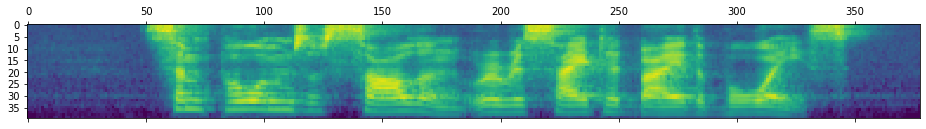

In [8]:
cut.plot_features()

In [42]:
def plot_alignments(self, cut):
    import matplotlib.pyplot as plt
    feats = self.compute_features(cut)
    phone_ids = self.align(cut)
    fig, axes = plt.subplots(2, squeeze=True, sharey=True, figsize=(10, 6))
    axes[0].imshow(np.flipud(feats[0].T))
    axes[1].imshow(torch.nn.functional.one_hot(phone_ids.repeat_interleave(4).to(torch.int64)).T)
    return fig, axes


def plot_posteriors(self, cut):
    import matplotlib.pyplot as plt
    feats = self.compute_features(cut)
    posteriors = self.compute_posteriors(cut)
    fig, axes = plt.subplots(2, squeeze=True, sharey=True, figsize=(10, 6))
    axes[0].imshow(np.flipud(feats[0].T))
    axes[1].imshow(posteriors[0].exp().repeat_interleave(4, 1))
    return fig, axes

(<Figure size 720x432 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

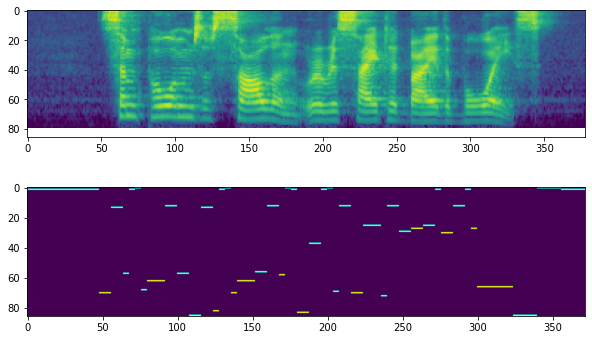

In [43]:
asr.plot_alignments(cut)

(<Figure size 720x432 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

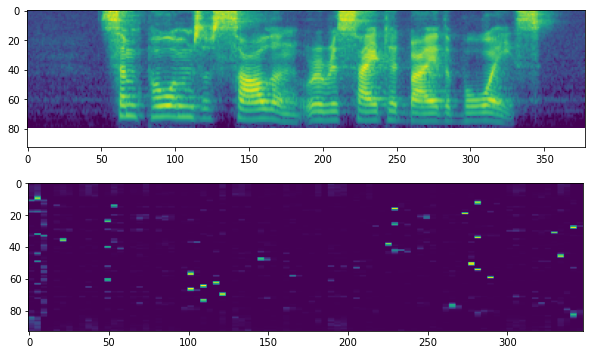

In [44]:
asr.plot_posteriors(cut)

(<Figure size 720x1008 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

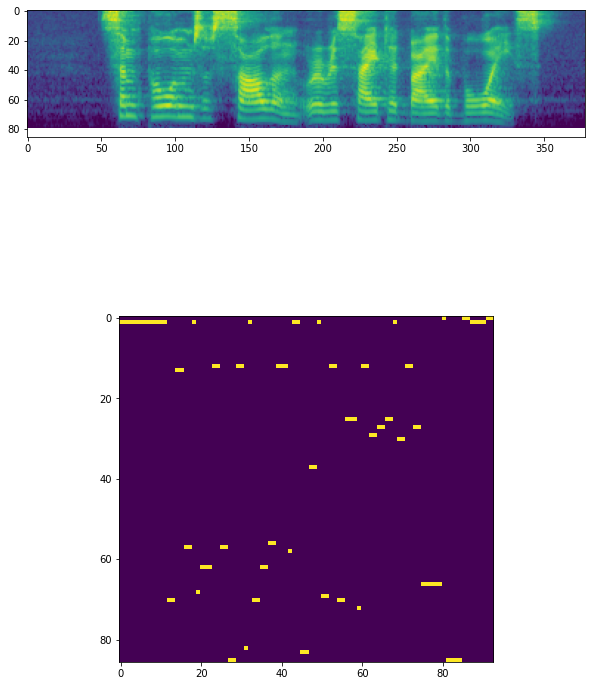

In [9]:
asr.plot_alignments(cut)

In [46]:
lang_dir = Path('data/lang_nosp')
# model_dir = Path('exp-conformer-noam-mmi-att-musan-sa-10ep-4gpu')
model_dir = Path('exp-conformer-noam-mmi-att-musan-sa-vgg')
# model_dir = Path('exp-conformer-noam-mmi-att-musan-sa-vgg-adv-pgd-3')
device = torch.device('cpu')  #torch.device('cuda:0')

lexicon = Lexicon(lang_dir)
phone_ids = lexicon.phone_symbols()

model = Conformer(
    num_features=80,
    num_classes=len(phone_ids) + 1,
    num_decoder_layers=0,
    vgg_frontend=True
)
P = create_bigram_phone_lm(phone_ids).to(device)
P.scores = torch.zeros_like(P.scores)
model.P_scores = nn.Parameter(P.scores.clone(), requires_grad=True)

# average_checkpoint(
#     filenames=[model_dir / f'epoch-{n}.pt' for n in [15, 16, 17, 18, 19]],
#     model=model
# );
average_checkpoint(
    filenames=[model_dir / f'epoch-{n}.pt' for n in [19]],
    model=model
);

model = torch.jit.script(model)

model = model.to(device)

In [8]:
model.save('conformer-jit.pt')

In [5]:
# model_dir_adv = Path('exp-conformer-noam-mmi-att-musan-sa-vgg-adv-pgd-3')
# model_adv = Conformer(
#     num_features=80,
#     num_classes=len(phone_ids) + 1,
#     num_decoder_layers=0,
#     vgg_frontend=True
# )
# P_adv = create_bigram_phone_lm(phone_ids).to(device)
# P_adv.scores = torch.zeros_like(P_adv.scores)
# model_adv.P_scores = nn.Parameter(P_adv.scores.clone(), requires_grad=True)
# average_checkpoint(
#     filenames=[model_dir_adv / f'epoch-{n}.pt' for n in [22]],
#     model=model_adv
# );
# model_adv = model_adv.to(device)

In [47]:
# Loading pre-compiled HLG"
d = torch.load(lang_dir / 'HLG.pt')
HLG = k2.Fsa.from_dict(d)
HLG = HLG.to(device)

In [48]:
symbols = k2.SymbolTable.from_file(lang_dir / 'words.txt')

In [45]:
cs = load_manifest('exp/data/cuts_test-clean.json.gz')
dset = K2SpeechRecognitionDataset(cs, input_strategy=AudioSamples(), return_cuts=True)
sampler = SingleCutSampler(cs, max_cuts=16)
dloader = DataLoader(dset, sampler=sampler, batch_size=None)


fe = Fbank(FbankConfig(num_mel_bins=80))

otf = OnTheFlyFeatures(fe)

In [49]:
cut = cs[0]

In [50]:
dloader_iter = iter(dloader)

In [51]:
for i in range(20):
    batch = next(dloader_iter)

In [12]:
sample_idx = 0

In [13]:
fbank = Wav2LogFilterBank()

In [53]:
feats, segments = feature_extraction(batch['inputs'].clone(), batch['supervisions'], compute_gradient=True)
feats = feats.permute(0, 2, 1)

torch.Size([16, 80, 2540])


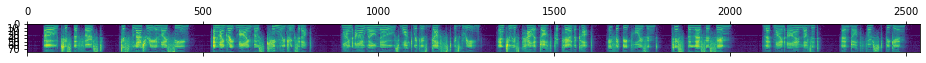

In [15]:
print(feats.shape); plt.matshow(feats[sample_idx].detach().numpy())

torch.Size([16, 80, 2540])


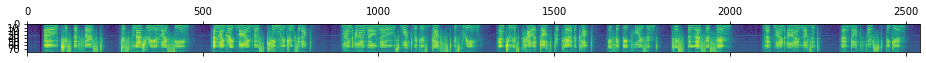

In [16]:
feats, segments = feature_extraction2(batch['inputs'].clone(), batch['supervisions'], compute_gradient=True)
feats = feats.permute(0, 2, 1)
print(feats.shape); plt.matshow(feats[sample_idx].detach().numpy())

In [54]:
%%timeit
with torch.no_grad():
    preds, _, _ = model(feats.to(device))
# print(preds.shape); plt.matshow(preds[sample_idx].cpu().exp().numpy())

22.7 s ± 201 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%%timeit
with torch.no_grad():
    preds, _, _ = model(feats.to(device))
# print(preds.shape); plt.matshow(preds[sample_idx].cpu().exp().numpy())

132 ms ± 150 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


torch.Size([16, 87, 634])


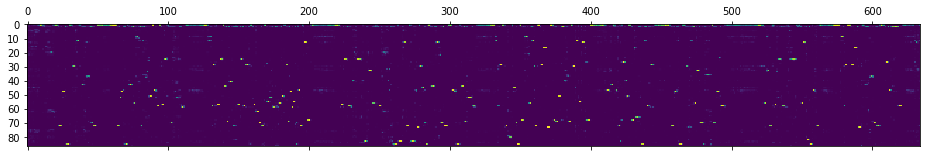

In [19]:
with torch.no_grad():
    preds, _, _ = model(feats.to(device))
print(preds.shape); plt.matshow(preds[sample_idx].cpu().exp().numpy())

In [20]:
# with torch.no_grad():
#     preds, _, _ = model_adv(feats.to(device))
# print(preds.shape); plt.matshow(preds[sample_idx].cpu().exp().numpy())

In [21]:
print(feats.shape[2], preds.shape[2], feats.shape[2] / preds.shape[2])

2540 634 4.006309148264984


# Adversarial

In [22]:
from snowfall.objectives.mmi import LFMMILoss

gc = MmiTrainingGraphCompiler(lexicon=lexicon, device=device)
loss_fn = LFMMILoss(
    graph_compiler=gc,
    P=P,
    den_scale=1.0
)

In [23]:
sups = torch.stack(
    (segments['sequence_idx'],
     (((segments['start_frame'] - 1) // 2 - 1) // 2),
     (((segments['num_frames'] - 1) // 2 - 1) // 2)), 1).to(torch.int32)

In [24]:
loss, tot_frames, all_frames = loss_fn(preds.permute(0, 2, 1), segments['text'], sups)
- loss / tot_frames

TypeError: linear_fsa(): incompatible function arguments. The following argument types are supported:
    1. (labels: List[int], gpu_id: int = -1) -> k2::Ragged<k2::Arc>
    2. (labels: List[List[int]], gpu_id: int = -1) -> k2::Ragged<k2::Arc>
    3. (labels: k2::Ragged<int>, gpu_id: int) -> k2::Ragged<k2::Arc>

Invoked with: [[123735, 178096, 175815, 62647, 178096, 63162, 86207, 119154, 157154, 5390, 119154, 73540, 114011, 117388, 95351, 51101, 89693, 186767, 114039, 59222, 193596, 96236, 194183, 196093, 81489, 75589, 89384, 185350, 5390, 178285, 81489, 128790, 50277, 139157, 175815, 41283, 85094, 89693, 13819, 136681, 178096, 175815, 101058, 161517, 175762, 114039, 59222, 104488, 89693, 5390, 50277, 62647, 14607], [75092, 24572, 198698, 83397, 193127, 113458, 169555, 179648, 43744, 127302, 125614, 118857, 125532, 6074, 21545, 177027, 68111, 88636, 196093, 82199, 194343, 161178, 137501, 24076, 16320, 175815, 150079, 24572, 137387, 194343, 17198, 15286, 178285, 36141, 436, 73626, 192882, 156591, 196093, 102117, 135710], [1, 163152, 158447, 76055, 14456, 65237, 24572, 117025, 59976, 125482, 159977, 39805, 5390, 80164, 125482, 175815, 176444, 124609, 124325, 53835, 176445, 53834, 1, 35416, 124609, 182869, 84030, 5390, 65068, 61158, 186866, 175815, 77322, 158453, 5390, 24392, 1, 156123], [6072, 5390, 60138, 116846, 85999, 145113, 175679, 175815, 44856, 124609, 1, 128698, 124609, 54953, 71277, 85831, 80566, 9366, 176452, 177716, 178285, 157159, 5159, 88607, 196093, 1, 132957, 124609, 163902, 117957, 138427, 5390, 1173, 86207, 175815, 1992, 124609, 175815, 158447], [195337, 40036, 78801, 164143, 5390, 185350, 194814, 76055, 31628, 81489, 38618, 1132, 175815, 49929, 124609, 81489, 198725, 109902, 29386, 166547, 186767, 9366, 125503, 86207, 6128], [64778, 3720, 175905, 193203, 176238, 157364, 175905, 26003, 5390, 156608, 177027, 175815, 83293, 62347, 5159, 124168, 129461, 181989, 10590, 86207, 164497, 124369, 37977], [175762, 58069, 181433, 68707, 1, 72994, 11741, 86207, 175815, 128748, 178285, 194411, 175815, 117388, 85999, 124609, 175815, 185350, 5390, 175815, 18601, 193805, 88946], [78801, 148198, 27400, 81489, 92601, 160027, 194411, 7571, 140857, 8525, 198698, 7571, 10585, 196093, 158504, 159108, 166033], [119154, 155675, 78055, 14456, 100296, 189383, 137405, 24383, 78801, 89384, 77447, 196894, 5390, 87004, 78801, 195337, 49087, 193596], [64415, 1, 66775, 83279, 78801, 76055, 128360, 186767, 5390, 50524, 191794, 24383, 78801, 38663, 191781, 122310, 103732], [135940, 64790, 110875, 64415, 176452, 184381, 193059, 124609, 1572, 84743, 76055, 182440, 65068], [84743, 76055, 2214, 14456, 1152, 184329, 175815, 87295, 124609, 176452, 108143, 138427], [198752, 135846, 118985, 13819, 123041, 112316, 1, 72062, 135846, 24383, 1, 170323, 125532], [175815, 82859, 157197, 59166, 48677], [177233, 86207, 30208, 50888], [29756, 158479, 125482, 175815, 143256, 124609, 107633]], None

In [53]:
audio = batch['inputs'].to(device)
Audio(audio[sample_idx].cpu().numpy(), rate=cut.sampling_rate)

In [54]:
batch['supervisions']['text']

["O TIS THE FIRST TIS FLATTERY IN MY SEEING AND MY GREAT MIND MOST KINGLY DRINKS IT UP MINE EYE WELL KNOWS WHAT WITH HIS GUST IS GREEING AND TO HIS PALATE DOTH PREPARE THE CUP IF IT BE POISON'D TIS THE LESSER SIN THAT MINE EYE LOVES IT AND DOTH FIRST BEGIN",
 "GUIDED BY YOU HOW WE MIGHT STROLL TOWARDS DEATH OUR ONLY MUSIC ONE ANOTHER'S BREATH THROUGH GARDENS INTIMATE WITH HOLLYHOCKS WHERE SILENT POPPIES BURN BETWEEN THE ROCKS BY POOLS WHERE BIRCHES BEND TO CONFIDANTS ABOVE GREEN WATERS SCUMMED WITH LILY PLANTS",
 'A SMALL SETTLEMENT HAD BEEN FOUNDED BY MORMON FAMILIES ON SHOAL CREEK AND HERE ON THE THIRTIETH OF OCTOBER EIGHTEEN THIRTY EIGHT A COMPANY OF TWO HUNDRED AND FORTY FELL UPON THE HAPLESS SETTLERS AND BUTCHERED A SCORE',
 'ANOTHER AND FAR MORE IMPORTANT REASON THAN THE DELIVERY OF A PAIR OF EMBROIDERED GLOVES IMPELLED HESTER AT THIS TIME TO SEEK AN INTERVIEW WITH A PERSONAGE OF SO MUCH POWER AND ACTIVITY IN THE AFFAIRS OF THE SETTLEMENT',
 "WILL CRIED HE SOFTLY AND STUTELEY WHO

## FGSM

In [55]:
audio = batch['inputs'].to(device)
audio_adv = fgsm_attack(
    audio,
    segments,
    sups,
    segments['text'],
    model,
    loss_fn,
    device=device,
    eps=0.01
)
diff = audio_adv - audio

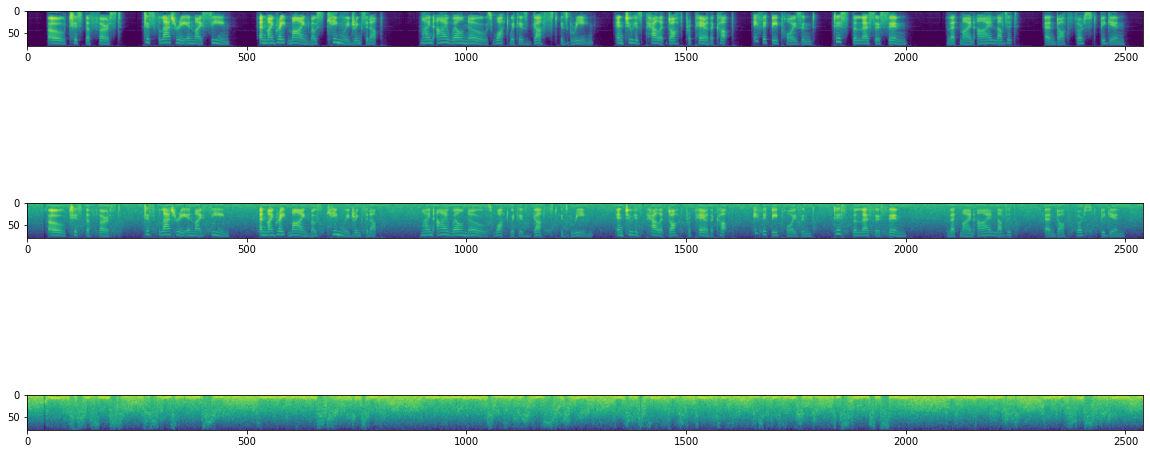

In [56]:
from IPython.display import Audio
fig, axes = plt.subplots(3, 1, figsize=(20,10))
axes[0].imshow(np.flipud(fe.extract(audio[sample_idx].cpu(), cut.sampling_rate).T));
axes[1].imshow(np.flipud(fe.extract(audio_adv[sample_idx].cpu(), cut.sampling_rate).T));
axes[2].imshow(np.flipud(fe.extract(diff[sample_idx].cpu(), cut.sampling_rate).T));
Audio(audio_adv[sample_idx].cpu().numpy(), rate=cut.sampling_rate)

## PGD

In [30]:
audio = batch['inputs'].to(device)
audio_adv = pgd_attack(
    audio,
    segments,
    sups,
    segments['text'],
    model,
    loss_fn,
    device=device,
    eps=0.01,
    iters=5
)
diff = audio_adv - audio

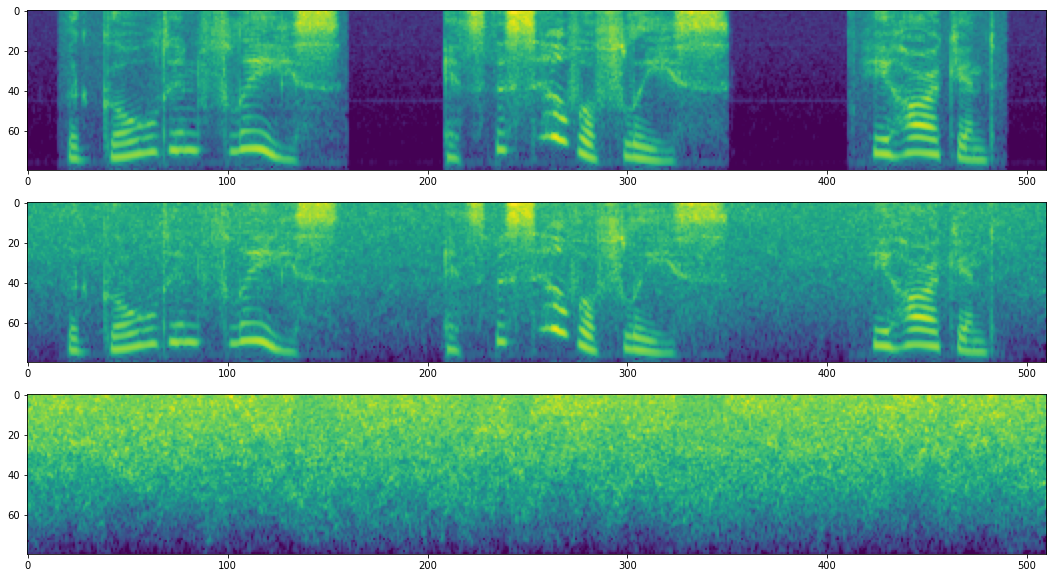

In [31]:
fig, axes = plt.subplots(3, 1, figsize=(20,10))
axes[0].imshow(np.flipud(fe.extract(audio[sample_idx].cpu(), cut.sampling_rate).T));
axes[1].imshow(np.flipud(fe.extract(audio_adv[sample_idx].cpu(), cut.sampling_rate).T));
axes[2].imshow(np.flipud(fe.extract(diff[sample_idx].cpu(), cut.sampling_rate).T));
Audio(audio_adv[sample_idx].cpu().numpy(), rate=cut.sampling_rate)

## Feats of attacked signal for inference

In [57]:
from lhotse.augmentation import Speed
from copy import copy

In [58]:
factor = 1.05
speed = Speed(factor)
speed2 = Speed(1 / factor)

In [59]:
feats, segments = feature_extraction(audio.clone(), batch['supervisions'], compute_gradient=False)
feats = feats.permute(0, 2, 1)
feats_adv, segments_adv = feature_extraction(audio_adv.clone(), batch['supervisions'], compute_gradient=False)
feats_adv = feats_adv.permute(0, 2, 1)

sp_supervisions = batch['supervisions'].copy()
sp_supervisions['start_sample'] = sp_supervisions['start_sample'] / factor
sp_supervisions['num_samples'] = sp_supervisions['num_samples'] / factor
feats_adv_sp, segments_adv_sp = feature_extraction(torch.from_numpy(speed(audio_adv.clone(), 16000)), sp_supervisions, compute_gradient=False)
feats_adv_sp = feats_adv_sp.permute(0, 2, 1)

RuntimeError: Input tensor has to be on CPU.

In [60]:
sups = torch.stack(
    (segments['sequence_idx'],
     (((segments['start_frame'] - 1) // 2 - 1) // 2),
     (((segments['num_frames'] - 1) // 2 - 1) // 2)), 1).to(torch.int32)
sups_adv = torch.stack(
    (segments_adv['sequence_idx'],
     (((segments_adv['start_frame'] - 1) // 2 - 1) // 2),
     (((segments_adv['num_frames'] - 1) // 2 - 1) // 2)), 1).to(torch.int32)
sups_adv_sp = torch.stack(
    (segments_adv_sp['sequence_idx'],
     (((segments_adv_sp['start_frame'] - 1) // 2 - 1) // 2),
     (((segments_adv_sp['num_frames'] - 1) // 2 - 1) // 2)), 1).to(torch.int32)

NameError: name 'segments_adv_sp' is not defined

In [61]:
print(sups, sups_adv, sups_adv_sp)

NameError: name 'sups_adv_sp' is not defined

NameError: name 'feats_adv_sp' is not defined

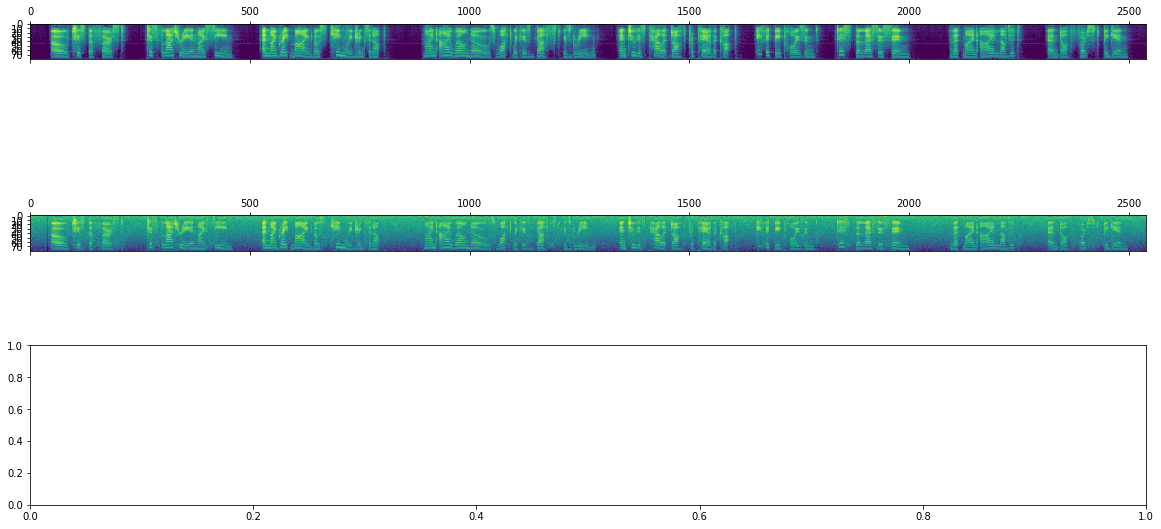

In [62]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10))
axes[0].matshow(np.flipud(feats[sample_idx].detach().cpu().numpy()))
axes[1].matshow(np.flipud(feats_adv[sample_idx].detach().cpu().numpy()))
axes[2].matshow(np.flipud(feats_adv_sp[sample_idx].detach().cpu().numpy()))

In [66]:
with torch.no_grad():
    preds_all, _, _ = model(torch.cat([feats, feats_adv], dim=0))
    preds = preds_all[:feats.shape[0]]
    preds_adv = preds_all[feats.shape[0]:]
    preds_adv_sp, _, _ = model(feats_adv_sp)

NameError: name 'feats_adv_sp' is not defined

NameError: name 'preds_adv_sp' is not defined

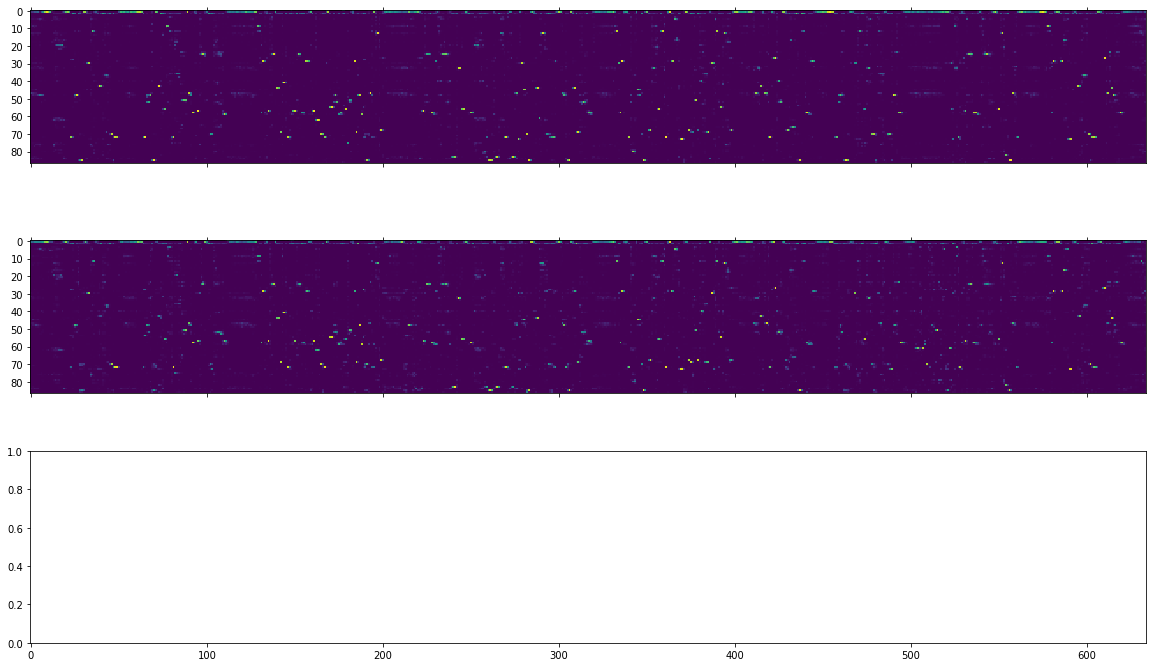

In [67]:
fig, axes = plt.subplots(3, 1, figsize=(20, 12), sharex=True)
axes[0].matshow(preds[sample_idx].exp().cpu().numpy())
axes[1].matshow(preds_adv[sample_idx].exp().cpu().numpy())
axes[2].matshow(preds_adv_sp[sample_idx].exp().cpu().numpy())

In [68]:
for msg, post, sup_segs in [('Clean:', preds, sups), ('Adversarial:', preds_adv, sups_adv), ('Adversarial (speed perturbed)', preds_adv_sp, sups_adv_sp)]:
    loss, tot_frames, all_frames = loss_fn(post.permute(0, 2, 1), segments['text'], sup_segs)
    print(msg)
    print('Loss:', -loss / tot_frames)

NameError: name 'preds_adv_sp' is not defined

In [69]:
print(feats.shape[2], preds.shape[2], feats.shape[2] / preds.shape[2])

2540 634 4.006309148264984


## Decode adversarial attacked utts

In [ ]:
texts = segments['text']

for msg, post, sup_segs in [('Clean:', preds, sups), ('Adversarial:', preds_adv, sups_adv)]: ('Adversarial (speed perturbed)', preds_adv_sp, sups_adv_sp)]:
    print(msg)
    dense_fsa_vec = k2.DenseFsaVec(post.permute(0, 2, 1), sup_segs)
    assert HLG.device == post.device, \
        f"Check failed: HLG.device ({HLG.device}) == nnet_output.device ({post.device})"
    # TODO(haowen): with a small `beam`, we may get empty `target_graph`,
    # thus `tot_scores` will be `inf`. Definitely we need to handle this later.
    lattices = k2.intersect_dense_pruned(HLG, dense_fsa_vec, 20.0, 10.0, 30, 10000)
    best_paths = k2.shortest_path(lattices, use_double_scores=True)
    
    assert best_paths.shape[0] == len(texts)
    indices = torch.tensor([0])
    hyps = get_texts(best_paths, indices)
    assert len(hyps) == len(texts)

    for i in range(len(texts)):
        hyp_words = [symbols.get(x) for x in hyps[i]]
        ref_words = texts[i].split(' ')
#         results.append((ref_words, hyp_words))
        print('REF:', ' '.join(ref_words))
        print('HYP:', ' '.join(hyp_words))



# Dumping adversarial recordings

In [ ]:
# Where we will write the examples
output_dir = Path('/exp/pzelasko/libri-960-train-adv')
output_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# Which audio data to attack
cs = load_manifest('exp/data/cuts_train-clean-100.json.gz') + load_manifest('exp/data/cuts_train-clean-360.json.gz') + load_manifest('exp/data/cuts_train-other-500.json.gz')

In [ ]:
# Pytorch Dataloader
dset = K2SpeechRecognitionDataset(cs, input_strategy=AudioSamples(), return_cuts=True)
sampler = SingleCutSampler(cs, max_duration=300, shuffle=True, seed=1)
dloader = DataLoader(dset, sampler=sampler, batch_size=None, num_workers=2)

In [ ]:
# Attacks to choose from
attack_classes = []
for eps in [0.0001, 0.001, 0.01]:
    attack_classes.append(['fgsm', eps, None])
    for iters in [5, 10, 20, 50, 100, 200]:
        attack_classes.append(['pgd', eps, iters])

In [ ]:
# Actual processing
for batch in tqdm(dloader, desc='Creating adversarial recordings'):
    # Read the audio from the batch
    audio = batch['inputs'].to(device)
    
    # Compute the expected number of frames
    segments = batch['supervisions']
    segments.update(otf.supervision_intervals(batch['supervisions']['cut']))
    sups = torch.stack(
        (
            segments['sequence_idx'],
            (((segments['start_frame'] - 1) // 2 - 1) // 2),
            (((segments['num_frames'] - 1) // 2 - 1) // 2) 
        ),
        dim=1
    ).to(torch.int32)
    
    # Select the attack to execute
    attack, eps, iters = random.choice(attack_classes)

    # Perform attack
    if attack == 'fgsm':
        audio_adv = fgsm_attack(
            audio,
            segments,
            sups,
            segments['text'],
            model,
            loss_fn,
            device=device,
            eps=eps
        )
    elif attack == 'pgd':
        audio_adv = pgd_attack(
            audio,
            segments,
            sups,
            segments['text'],
            model,
            loss_fn,
            device=device,
            eps=eps,
            iters=iters
        )
    else:
        raise ValueError("Unknown attack type: " + attack)
        
    # Convert to PCM INT16 format for writing
    audio_int16 = (audio_adv.detach() * INT16MAX).cpu().numpy().astype(np.int16)
        
    # For each recording, store the attacked variant.
    for idx, cut in enumerate(tqdm(batch['supervisions']['cut'], leave=False)):
        subdir_path = output_dir / f'{attack}_eps{eps:.0e}_it{iters}' / cut.supervisions[0].speaker
        subdir_path.mkdir(exist_ok=True, parents=True)
        audio_path = (subdir_path / f'{Path(cut.recording.sources[0].source).stem}.wav')
        if audio_path.exists():
            # Already exists? Skip it!
            continue
        begin, end = segments['start_sample'][idx], segments['num_samples'][idx]
        audio_to_write = audio_int16[idx][begin: end]
        soundfile.write(str(audio_path), audio_to_write, cut.sampling_rate, format='WAV', subtype='PCM_16')